In [3]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [11]:
# 개별 모델은 로지스틱 회귀와 KNN임
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


C:\Users\leeji\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\leeji\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

### 랜덤 포레스트

In [14]:
# 총 42개의 피처명 중복, 이 중복된 피처명에 _1 또는 _2를 추가로 부여해 새로운 피처명을 가진 DataFrame 반환하는 함수 만듦.
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                 columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                              if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [15]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()를 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


In [20]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth':[6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [22]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8,
                                min_samples_split=8, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9165


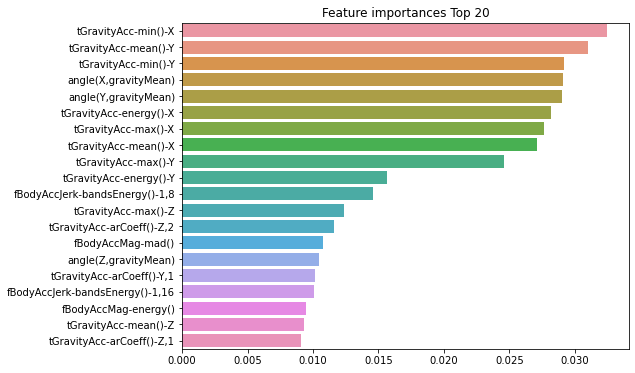

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### GBM(Gradient Boosting Machine)

In [27]:
# 부스팅 알고리즘 - 여러 개의 약한 학습기를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습
# GBM - 가중치 업데이트를 경사 하강법 이용
# 경사 하강법 - 반복수행을 통해 오류를 최소화할 수 있도록 가중치의 업데이트의 값을 도출하는 기법

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도:{0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f} 초'.format(time.time()-start_time))

GBM 정확도:0.9389
GBM 수행 시간: 531.8 초


In [28]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate':[0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 112.2min finished


최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 500}
최고 예측 정확도: 0.9011


### XGBoost(eXtra Gradient Boost)

In [3]:
import xgboost as xgb
from xgboost import XGBClassifier

In [4]:
import xgboost
print(xgboost.__version__)

1.2.0


In [5]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [6]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [7]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [8]:
# 학습용과 테스트용 데이터 세트를 위해 별도의 객체 DMatrix를 생성. XGBoost만의 전용 데이터 세트
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [9]:
params = {'max_depth' : 3,
         'eta' : 0.1,
         'objective' : 'binary:logistic',
         'eval_metric' : 'logloss',
         'early_stopping' : 100
         }
num_rounds = 400

In [10]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기합니다.
wlist = [(dtrain, 'train'), (dtest, 'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds,
                     early_stopping_rounds=100, evals=wlist)

[23:21:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.60969	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logl

[159]	train-logloss:0.00730	eval-logloss:0.08830
[160]	train-logloss:0.00728	eval-logloss:0.08828
[161]	train-logloss:0.00726	eval-logloss:0.08801
[162]	train-logloss:0.00724	eval-logloss:0.08776
[163]	train-logloss:0.00722	eval-logloss:0.08778
[164]	train-logloss:0.00720	eval-logloss:0.08778
[165]	train-logloss:0.00718	eval-logloss:0.08752
[166]	train-logloss:0.00716	eval-logloss:0.08754
[167]	train-logloss:0.00714	eval-logloss:0.08764
[168]	train-logloss:0.00712	eval-logloss:0.08739
[169]	train-logloss:0.00710	eval-logloss:0.08738
[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08696
[177]	train-logloss:0.00696	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:

In [11]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC_AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC_AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
    F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [13]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,     F1:0.9806, AUC:0.9951


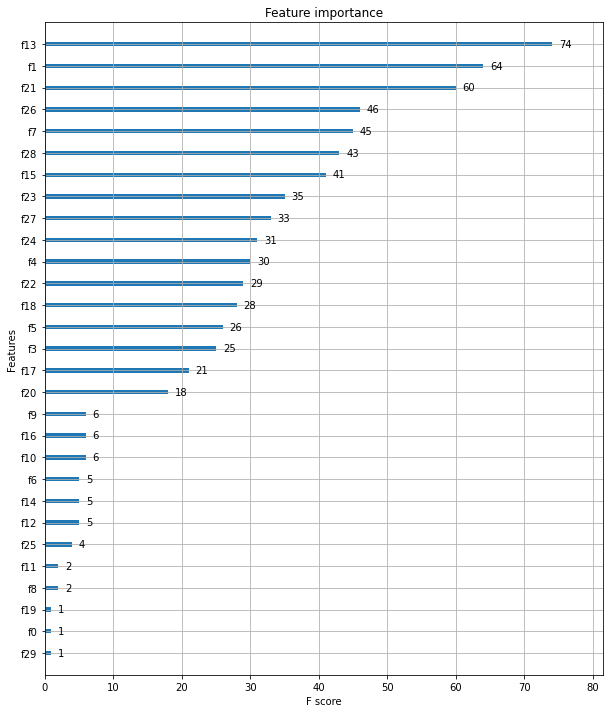

In [14]:
# xgboost의 plot_importance()는 피처의 중요도를 막대그래프 형식으로 나타냄.
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

In [18]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,     F1:0.9806, AUC:0.9951


In [19]:
from xgboost import XGBClassifier
''
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss',
               eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-loglo

[236]	validation_0-logloss:0.08629
[237]	validation_0-logloss:0.08622
[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08619
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08644
[263]	validation_0-logloss:0.08647
[264]	validation_0-l

In [20]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,     F1:0.9744, AUC:0.9954


In [21]:
# early_stopping_rounds를 10으로 설정하고 재학습.
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10,
               eval_metric='logloss', eval_set=evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-loglos

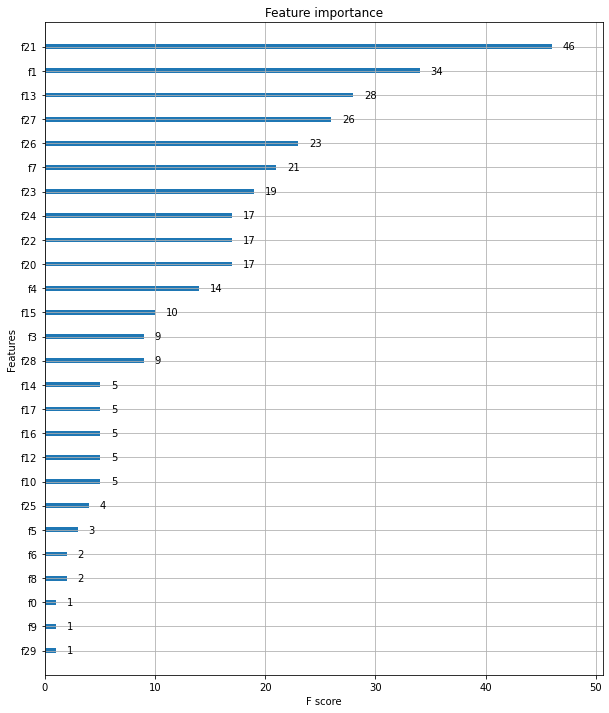

In [22]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

### LightGBM

In [2]:
# learning_rate를 작게 하면서 n_estimators를 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안임 / 과적합 주의

In [1]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightBGM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss',
                eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC_AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC_AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
    F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [4]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870,     F1:0.9682, AUC:0.9905


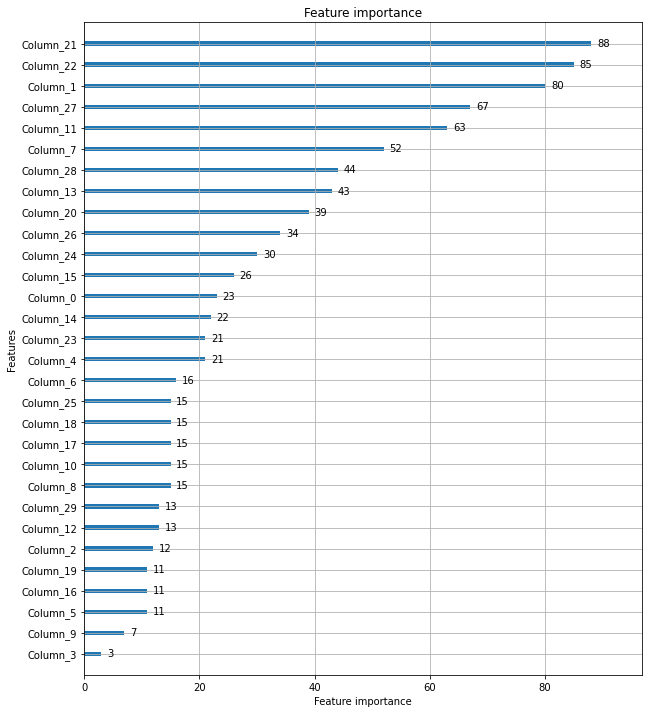

In [5]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

### 분류 실습 - 캐글 산탄데르 고객 만족 예측

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('./train_santander.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [2]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [3]:
# 전체 데이터에서 만족과 불만족의 비율 확인
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [4]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [5]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, 
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [7]:
# XGBoost 모델 학습
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
           eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82746
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85830	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84054
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.880

In [11]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max depth':[5, 7], 'min_child':[1, 3], 'colsample_bytree':[0.5, 0.75]}

# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',
          eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[22:35:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max depth, min_child } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79800	validation_1-auc:0.79715
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.82341	validation_1-auc:0.81629
[2]	validation_0-auc:0.83146	validation_1-auc:0.82274
[3]	validation_0-auc:0.83436	validation_1-auc:0.82608
[4]	validation_0-auc:0.83918	validation_1-auc:0.82931
[5]	validation_0-auc:0.84031	validation_1-auc:0.83260
[6]	validation_0-auc:0.84021	validation_1-auc:0.83082
[7]	validation_0-auc:0.84759	validation_1-auc:0.83535
[8]	validatio

[23]	validation_0-auc:0.87712	validation_1-auc:0.84066
[24]	validation_0-auc:0.87799	validation_1-auc:0.84081
[25]	validation_0-auc:0.87921	validation_1-auc:0.84057
[26]	validation_0-auc:0.88027	validation_1-auc:0.84030
[27]	validation_0-auc:0.88140	validation_1-auc:0.83999
[28]	validation_0-auc:0.88154	validation_1-auc:0.84041
[29]	validation_0-auc:0.88221	validation_1-auc:0.84071
[30]	validation_0-auc:0.88256	validation_1-auc:0.84037
[31]	validation_0-auc:0.88315	validation_1-auc:0.83998
[32]	validation_0-auc:0.88351	validation_1-auc:0.83982
[33]	validation_0-auc:0.88417	validation_1-auc:0.83957
[34]	validation_0-auc:0.88451	validation_1-auc:0.83981
[35]	validation_0-auc:0.88509	validation_1-auc:0.83970
[36]	validation_0-auc:0.88572	validation_1-auc:0.83987
[37]	validation_0-auc:0.88591	validation_1-auc:0.83963
[38]	validation_0-auc:0.88623	validation_1-auc:0.83920
[39]	validation_0-auc:0.88655	validation_1-auc:0.83876
[40]	validation_0-auc:0.88680	validation_1-auc:0.83838
[41]	valid

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.82645	validation_1-auc:0.82717
[2]	validation_0-auc:0.83428	validation_1-auc:0.83032
[3]	validation_0-auc:0.83574	validation_1-auc:0.83046
[4]	validation_0-auc:0.84067	validation_1-auc:0.83198
[5]	validation_0-auc:0.84347	validation_1-auc:0.83577
[6]	validation_0-auc:0.84360	validation_1-auc:0.83210
[7]	validation_0-auc:0.85249	validation_1-auc:0.83806
[8]	validation_0-auc:0.85553	validation_1-auc:0.83802
[9]	validation_0-auc:0.85522	validation_1-auc:0.83599
[10]	validation_0-auc:0.85580	validation_1-auc:0.83483
[11]	validation_0-auc:0.85518	validation_1-auc:0.83287
[12]	validation_0-auc:0.86188	validation_1-auc:0.83696
[13]	validation_0-auc:0.86573	validation_1-auc:0.83913
[14]	validation_0-auc:0.86763	validation_1-auc:0.84134
[15]	validation_0-auc:0.86880	validation_1-auc:0.84050
[16]	validation_0-auc:0.87050	validation_1-auc:0.84089
[17]	validation_0-auc:0.87259	validation_1-auc:0.84096
[18]	valid

[37]	validation_0-auc:0.88506	validation_1-auc:0.83935
[38]	validation_0-auc:0.88525	validation_1-auc:0.83939
[39]	validation_0-auc:0.88553	validation_1-auc:0.83938
[40]	validation_0-auc:0.88558	validation_1-auc:0.83922
[41]	validation_0-auc:0.88562	validation_1-auc:0.83944
[42]	validation_0-auc:0.88606	validation_1-auc:0.83914
[43]	validation_0-auc:0.88618	validation_1-auc:0.83913
[44]	validation_0-auc:0.88676	validation_1-auc:0.83864
[45]	validation_0-auc:0.88687	validation_1-auc:0.83867
[46]	validation_0-auc:0.88727	validation_1-auc:0.83884
[47]	validation_0-auc:0.88790	validation_1-auc:0.83878
[48]	validation_0-auc:0.88837	validation_1-auc:0.83864
Stopping. Best iteration:
[18]	validation_0-auc:0.87457	validation_1-auc:0.84218

[22:35:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max depth, min_child } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed d

[13]	validation_0-auc:0.86620	validation_1-auc:0.83979
[14]	validation_0-auc:0.86868	validation_1-auc:0.84161
[15]	validation_0-auc:0.87032	validation_1-auc:0.84032
[16]	validation_0-auc:0.87218	validation_1-auc:0.84194
[17]	validation_0-auc:0.87350	validation_1-auc:0.84174
[18]	validation_0-auc:0.87457	validation_1-auc:0.84218
[19]	validation_0-auc:0.87538	validation_1-auc:0.84158
[20]	validation_0-auc:0.87610	validation_1-auc:0.84098
[21]	validation_0-auc:0.87670	validation_1-auc:0.84028
[22]	validation_0-auc:0.87788	validation_1-auc:0.84063
[23]	validation_0-auc:0.87850	validation_1-auc:0.84146
[24]	validation_0-auc:0.87918	validation_1-auc:0.84121
[25]	validation_0-auc:0.87960	validation_1-auc:0.84176
[26]	validation_0-auc:0.88061	validation_1-auc:0.84118
[27]	validation_0-auc:0.88118	validation_1-auc:0.84140
[28]	validation_0-auc:0.88161	validation_1-auc:0.84136
[29]	validation_0-auc:0.88191	validation_1-auc:0.84069
[30]	validation_0-auc:0.88204	validation_1-auc:0.84042
[31]	valid

[22:36:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max depth, min_child } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.81196	validation_1-auc:0.80437
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.82442	validation_1-auc:0.81883
[2]	validation_0-auc:0.82975	validation_1-auc:0.81760
[3]	validation_0-auc:0.83546	validation_1-auc:0.82375
[4]	validation_0-auc:0.84259	validation_1-auc:0.83042
[5]	validation_0-auc:0.84664	validation_1-auc:0.83196
[6]	validation_0-auc:0.85126	validation_1-auc:0.83477
[7]	validation_0-auc:0.85497	validation_1-auc:0.83659
[8]	validatio

[21]	validation_0-auc:0.87572	validation_1-auc:0.83403
[22]	validation_0-auc:0.87592	validation_1-auc:0.83400
[23]	validation_0-auc:0.87615	validation_1-auc:0.83449
[24]	validation_0-auc:0.87623	validation_1-auc:0.83433
[25]	validation_0-auc:0.87636	validation_1-auc:0.83398
[26]	validation_0-auc:0.87684	validation_1-auc:0.83318
[27]	validation_0-auc:0.87763	validation_1-auc:0.83262
[28]	validation_0-auc:0.87764	validation_1-auc:0.83257
[29]	validation_0-auc:0.87771	validation_1-auc:0.83243
[30]	validation_0-auc:0.87828	validation_1-auc:0.83257
[31]	validation_0-auc:0.87841	validation_1-auc:0.83285
[32]	validation_0-auc:0.87875	validation_1-auc:0.83289
[33]	validation_0-auc:0.87879	validation_1-auc:0.83252
[34]	validation_0-auc:0.87982	validation_1-auc:0.83186
[35]	validation_0-auc:0.88005	validation_1-auc:0.83184
[36]	validation_0-auc:0.88050	validation_1-auc:0.83160
[37]	validation_0-auc:0.88207	validation_1-auc:0.83152
[38]	validation_0-auc:0.88191	validation_1-auc:0.83105
[39]	valid

[0]	validation_0-auc:0.81542	validation_1-auc:0.81038
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.83055	validation_1-auc:0.82459
[2]	validation_0-auc:0.83244	validation_1-auc:0.82642
[3]	validation_0-auc:0.83423	validation_1-auc:0.82506
[4]	validation_0-auc:0.83885	validation_1-auc:0.82956
[5]	validation_0-auc:0.84072	validation_1-auc:0.83112
[6]	validation_0-auc:0.84416	validation_1-auc:0.83144
[7]	validation_0-auc:0.84792	validation_1-auc:0.83362
[8]	validation_0-auc:0.85216	validation_1-auc:0.83531
[9]	validation_0-auc:0.85605	validation_1-auc:0.83554
[10]	validation_0-auc:0.85714	validation_1-auc:0.83436
[11]	validation_0-auc:0.85640	validation_1-auc:0.83151
[12]	validation_0-auc:0.86150	validation_1-auc:0.83439
[13]	validation_0-auc:0.86462	validation_1-auc:0.83799
[14]	validation_0-auc:0.86683	validation_1-auc:0.83748
[15]	validation_0-auc:0.8686

[34]	validation_0-auc:0.88534	validation_1-auc:0.83803
[35]	validation_0-auc:0.88575	validation_1-auc:0.83783
[36]	validation_0-auc:0.88621	validation_1-auc:0.83813
[37]	validation_0-auc:0.88631	validation_1-auc:0.83786
[38]	validation_0-auc:0.88695	validation_1-auc:0.83726
[39]	validation_0-auc:0.88698	validation_1-auc:0.83712
[40]	validation_0-auc:0.88712	validation_1-auc:0.83710
[41]	validation_0-auc:0.88728	validation_1-auc:0.83714
[42]	validation_0-auc:0.88758	validation_1-auc:0.83662
[43]	validation_0-auc:0.88769	validation_1-auc:0.83668
[44]	validation_0-auc:0.88803	validation_1-auc:0.83617
[45]	validation_0-auc:0.88888	validation_1-auc:0.83563
[46]	validation_0-auc:0.89026	validation_1-auc:0.83545
[47]	validation_0-auc:0.89075	validation_1-auc:0.83549
[48]	validation_0-auc:0.89183	validation_1-auc:0.83539
[49]	validation_0-auc:0.89197	validation_1-auc:0.83510
Stopping. Best iteration:
[19]	validation_0-auc:0.87535	validation_1-auc:0.84160

[22:37:23] WARNING: C:\Users\Administr

[9]	validation_0-auc:0.85760	validation_1-auc:0.83892
[10]	validation_0-auc:0.85904	validation_1-auc:0.83847
[11]	validation_0-auc:0.85972	validation_1-auc:0.83735
[12]	validation_0-auc:0.86450	validation_1-auc:0.83712
[13]	validation_0-auc:0.86796	validation_1-auc:0.83970
[14]	validation_0-auc:0.86915	validation_1-auc:0.83973
[15]	validation_0-auc:0.87099	validation_1-auc:0.84045
[16]	validation_0-auc:0.87203	validation_1-auc:0.84021
[17]	validation_0-auc:0.87302	validation_1-auc:0.84074
[18]	validation_0-auc:0.87368	validation_1-auc:0.84049
[19]	validation_0-auc:0.87535	validation_1-auc:0.84160
[20]	validation_0-auc:0.87618	validation_1-auc:0.84120
[21]	validation_0-auc:0.87743	validation_1-auc:0.84148
[22]	validation_0-auc:0.87818	validation_1-auc:0.84105
[23]	validation_0-auc:0.87887	validation_1-auc:0.84062
[24]	validation_0-auc:0.87986	validation_1-auc:0.84011
[25]	validation_0-auc:0.88063	validation_1-auc:0.84008
[26]	validation_0-auc:0.88123	validation_1-auc:0.83979
[27]	valida

In [13]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,
                       min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200,
           eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.73501	validation_1-auc:0.74128
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.82359	validation_1-auc:0.81776
[2]	validation_0-auc:0.81094	validation_1-auc:0.80194
[3]	validation_0-auc:0.81288	validation_1-auc:0.80637
[4]	validation_0-auc:0.82564	validation_1-auc:0.81831
[5]	validation_0-auc:0.83066	validation_1-auc:0.82196
[6]	validation_0-auc:0.83608	validation_1-auc:0.82734
[7]	validation_0-auc:0.83832	validation_1-auc:0.82902
[8]	validation_0-auc:0.84104	validation_1-auc:0.83114
[9]	validation_0-auc:0.84000	validation_1-auc:0.83020
[10]	validation_0-auc:0.84155	validation_1-auc:0.83071
[11]	validation_0-auc:0.84090	validation_1-auc:0.82996
[12]	validation_0-auc:0.84176	validation_1-auc:0.83039
[13]	validation_0-auc:0.83970	validation_1-auc:0.82909
[14]	validation_0-auc:0.84151	validation_1-auc:0.83008
[15]	validation_0-auc:0.844

[146]	validation_0-auc:0.87947	validation_1-auc:0.84328
[147]	validation_0-auc:0.87971	validation_1-auc:0.84318
[148]	validation_0-auc:0.87989	validation_1-auc:0.84332
[149]	validation_0-auc:0.88005	validation_1-auc:0.84340
[150]	validation_0-auc:0.88030	validation_1-auc:0.84355
[151]	validation_0-auc:0.88060	validation_1-auc:0.84368
[152]	validation_0-auc:0.88085	validation_1-auc:0.84378
[153]	validation_0-auc:0.88106	validation_1-auc:0.84380
[154]	validation_0-auc:0.88126	validation_1-auc:0.84384
[155]	validation_0-auc:0.88150	validation_1-auc:0.84387
[156]	validation_0-auc:0.88160	validation_1-auc:0.84388
[157]	validation_0-auc:0.88187	validation_1-auc:0.84398
[158]	validation_0-auc:0.88208	validation_1-auc:0.84413
[159]	validation_0-auc:0.88228	validation_1-auc:0.84415
[160]	validation_0-auc:0.88255	validation_1-auc:0.84416
[161]	validation_0-auc:0.88287	validation_1-auc:0.84411
[162]	validation_0-auc:0.88300	validation_1-auc:0.84393
[163]	validation_0-auc:0.88312	validation_1-auc:

[293]	validation_0-auc:0.90476	validation_1-auc:0.84365
[294]	validation_0-auc:0.90485	validation_1-auc:0.84362
[295]	validation_0-auc:0.90490	validation_1-auc:0.84359
[296]	validation_0-auc:0.90494	validation_1-auc:0.84358
[297]	validation_0-auc:0.90502	validation_1-auc:0.84353
[298]	validation_0-auc:0.90514	validation_1-auc:0.84359
[299]	validation_0-auc:0.90521	validation_1-auc:0.84360
[300]	validation_0-auc:0.90528	validation_1-auc:0.84360
[301]	validation_0-auc:0.90532	validation_1-auc:0.84356
[302]	validation_0-auc:0.90539	validation_1-auc:0.84351
[303]	validation_0-auc:0.90544	validation_1-auc:0.84354
[304]	validation_0-auc:0.90550	validation_1-auc:0.84352
[305]	validation_0-auc:0.90559	validation_1-auc:0.84349
[306]	validation_0-auc:0.90578	validation_1-auc:0.84348
[307]	validation_0-auc:0.90582	validation_1-auc:0.84351
[308]	validation_0-auc:0.90588	validation_1-auc:0.84350
[309]	validation_0-auc:0.90595	validation_1-auc:0.84340
[310]	validation_0-auc:0.90601	validation_1-auc:

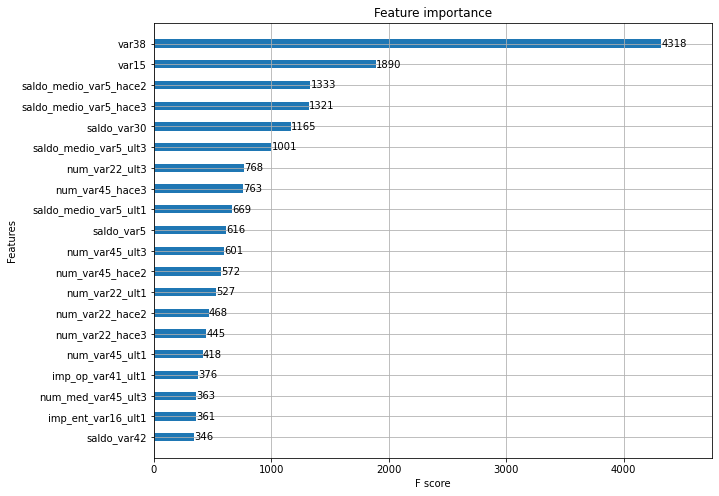

In [14]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

In [15]:
# LightGBM 모델 학습
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals,
            verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_loglos

In [16]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32, 64],
         'max_depth':[128, 160],
         'min_child_samples':[60, 100],
         'subsample':[0.8, 1]}

# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',
          eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	val

[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	va

[26]	valid_0's auc: 0.870183	valid_0's binary_logloss: 0.125414	valid_1's auc: 0.83333	valid_1's binary_logloss: 0.140724
[27]	valid_0's auc: 0.870926	valid_0's binary_logloss: 0.125123	valid_1's auc: 0.832503	valid_1's binary_logloss: 0.140772
[28]	valid_0's auc: 0.872431	valid_0's binary_logloss: 0.124766	valid_1's auc: 0.832826	valid_1's binary_logloss: 0.140685
[29]	valid_0's auc: 0.873397	valid_0's binary_logloss: 0.124495	valid_1's auc: 0.833175	valid_1's binary_logloss: 0.140604
[30]	valid_0's auc: 0.87475	valid_0's binary_logloss: 0.12417	valid_1's auc: 0.833614	valid_1's binary_logloss: 0.140497
[31]	valid_0's auc: 0.875407	valid_0's binary_logloss: 0.12389	valid_1's auc: 0.833706	valid_1's binary_logloss: 0.140428
[32]	valid_0's auc: 0.876136	valid_0's binary_logloss: 0.123637	valid_1's auc: 0.833458	valid_1's binary_logloss: 0.140448
[33]	valid_0's auc: 0.876575	valid_0's binary_logloss: 0.123421	valid_1's auc: 0.832965	valid_1's binary_logloss: 0.140498
[34]	valid_0's auc: 

[26]	valid_0's auc: 0.870325	valid_0's binary_logloss: 0.125518	valid_1's auc: 0.839261	valid_1's binary_logloss: 0.139524
[27]	valid_0's auc: 0.871488	valid_0's binary_logloss: 0.125147	valid_1's auc: 0.839671	valid_1's binary_logloss: 0.139365
[28]	valid_0's auc: 0.87235	valid_0's binary_logloss: 0.12484	valid_1's auc: 0.840114	valid_1's binary_logloss: 0.139236
[29]	valid_0's auc: 0.872991	valid_0's binary_logloss: 0.124593	valid_1's auc: 0.839491	valid_1's binary_logloss: 0.139271
[30]	valid_0's auc: 0.874129	valid_0's binary_logloss: 0.124312	valid_1's auc: 0.839589	valid_1's binary_logloss: 0.13918
[31]	valid_0's auc: 0.875305	valid_0's binary_logloss: 0.123988	valid_1's auc: 0.839441	valid_1's binary_logloss: 0.139184
[32]	valid_0's auc: 0.875943	valid_0's binary_logloss: 0.123748	valid_1's auc: 0.839268	valid_1's binary_logloss: 0.13919
[33]	valid_0's auc: 0.876575	valid_0's binary_logloss: 0.123484	valid_1's auc: 0.839549	valid_1's binary_logloss: 0.139075
[34]	valid_0's auc: 

[36]	valid_0's auc: 0.893984	valid_0's binary_logloss: 0.116353	valid_1's auc: 0.827203	valid_1's binary_logloss: 0.14207
[37]	valid_0's auc: 0.89456	valid_0's binary_logloss: 0.11603	valid_1's auc: 0.827292	valid_1's binary_logloss: 0.142005
[38]	valid_0's auc: 0.89511	valid_0's binary_logloss: 0.115713	valid_1's auc: 0.827214	valid_1's binary_logloss: 0.14206
[39]	valid_0's auc: 0.895738	valid_0's binary_logloss: 0.115415	valid_1's auc: 0.82695	valid_1's binary_logloss: 0.142162
Early stopping, best iteration is:
[9]	valid_0's auc: 0.863391	valid_0's binary_logloss: 0.132468	valid_1's auc: 0.835623	valid_1's binary_logloss: 0.145549
[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 

[35]	valid_0's auc: 0.894232	valid_0's binary_logloss: 0.116323	valid_1's auc: 0.8359	valid_1's binary_logloss: 0.140396
[36]	valid_0's auc: 0.895003	valid_0's binary_logloss: 0.115986	valid_1's auc: 0.835855	valid_1's binary_logloss: 0.140416
[37]	valid_0's auc: 0.895898	valid_0's binary_logloss: 0.115609	valid_1's auc: 0.836185	valid_1's binary_logloss: 0.140369
[38]	valid_0's auc: 0.896459	valid_0's binary_logloss: 0.11527	valid_1's auc: 0.835754	valid_1's binary_logloss: 0.140443
[39]	valid_0's auc: 0.897377	valid_0's binary_logloss: 0.114873	valid_1's auc: 0.835638	valid_1's binary_logloss: 0.140474
[40]	valid_0's auc: 0.89776	valid_0's binary_logloss: 0.114588	valid_1's auc: 0.835639	valid_1's binary_logloss: 0.140491
[41]	valid_0's auc: 0.898583	valid_0's binary_logloss: 0.114302	valid_1's auc: 0.835705	valid_1's binary_logloss: 0.140506
[42]	valid_0's auc: 0.899197	valid_0's binary_logloss: 0.113975	valid_1's auc: 0.835052	valid_1's binary_logloss: 0.14064
[43]	valid_0's auc: 0

[19]	valid_0's auc: 0.88046	valid_0's binary_logloss: 0.123313	valid_1's auc: 0.834629	valid_1's binary_logloss: 0.140738
[20]	valid_0's auc: 0.881517	valid_0's binary_logloss: 0.12269	valid_1's auc: 0.8347	valid_1's binary_logloss: 0.140611
[21]	valid_0's auc: 0.882464	valid_0's binary_logloss: 0.122095	valid_1's auc: 0.834656	valid_1's binary_logloss: 0.140487
[22]	valid_0's auc: 0.883744	valid_0's binary_logloss: 0.121504	valid_1's auc: 0.834562	valid_1's binary_logloss: 0.140328
[23]	valid_0's auc: 0.885301	valid_0's binary_logloss: 0.12091	valid_1's auc: 0.835278	valid_1's binary_logloss: 0.140199
[24]	valid_0's auc: 0.886266	valid_0's binary_logloss: 0.120437	valid_1's auc: 0.835728	valid_1's binary_logloss: 0.140094
[25]	valid_0's auc: 0.88755	valid_0's binary_logloss: 0.119931	valid_1's auc: 0.836199	valid_1's binary_logloss: 0.140076
[26]	valid_0's auc: 0.888525	valid_0's binary_logloss: 0.119473	valid_1's auc: 0.836708	valid_1's binary_logloss: 0.139945
[27]	valid_0's auc: 0.

[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	

[27]	valid_0's auc: 0.869014	valid_0's binary_logloss: 0.125868	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.139445
[28]	valid_0's auc: 0.869797	valid_0's binary_logloss: 0.12559	valid_1's auc: 0.837894	valid_1's binary_logloss: 0.139419
[29]	valid_0's auc: 0.870435	valid_0's binary_logloss: 0.1253	valid_1's auc: 0.838103	valid_1's binary_logloss: 0.139321
[30]	valid_0's auc: 0.87141	valid_0's binary_logloss: 0.125025	valid_1's auc: 0.838164	valid_1's binary_logloss: 0.139275
[31]	valid_0's auc: 0.872143	valid_0's binary_logloss: 0.124769	valid_1's auc: 0.837843	valid_1's binary_logloss: 0.139285
[32]	valid_0's auc: 0.872606	valid_0's binary_logloss: 0.124561	valid_1's auc: 0.837662	valid_1's binary_logloss: 0.139274
[33]	valid_0's auc: 0.873337	valid_0's binary_logloss: 0.124346	valid_1's auc: 0.837661	valid_1's binary_logloss: 0.139284
[34]	valid_0's auc: 0.873965	valid_0's binary_logloss: 0.124108	valid_1's auc: 0.837639	valid_1's binary_logloss: 0.139263
[35]	valid_0's auc: 

[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	

[26]	valid_0's auc: 0.868108	valid_0's binary_logloss: 0.126164	valid_1's auc: 0.838035	valid_1's binary_logloss: 0.139426
[27]	valid_0's auc: 0.869014	valid_0's binary_logloss: 0.125868	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.139445
[28]	valid_0's auc: 0.869797	valid_0's binary_logloss: 0.12559	valid_1's auc: 0.837894	valid_1's binary_logloss: 0.139419
[29]	valid_0's auc: 0.870435	valid_0's binary_logloss: 0.1253	valid_1's auc: 0.838103	valid_1's binary_logloss: 0.139321
[30]	valid_0's auc: 0.87141	valid_0's binary_logloss: 0.125025	valid_1's auc: 0.838164	valid_1's binary_logloss: 0.139275
[31]	valid_0's auc: 0.872143	valid_0's binary_logloss: 0.124769	valid_1's auc: 0.837843	valid_1's binary_logloss: 0.139285
[32]	valid_0's auc: 0.872606	valid_0's binary_logloss: 0.124561	valid_1's auc: 0.837662	valid_1's binary_logloss: 0.139274
[33]	valid_0's auc: 0.873337	valid_0's binary_logloss: 0.124346	valid_1's auc: 0.837661	valid_1's binary_logloss: 0.139284
[34]	valid_0's auc: 

[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	va

[36]	valid_0's auc: 0.893836	valid_0's binary_logloss: 0.117247	valid_1's auc: 0.836147	valid_1's binary_logloss: 0.139608
[37]	valid_0's auc: 0.894774	valid_0's binary_logloss: 0.116913	valid_1's auc: 0.836601	valid_1's binary_logloss: 0.139569
[38]	valid_0's auc: 0.895494	valid_0's binary_logloss: 0.116611	valid_1's auc: 0.836232	valid_1's binary_logloss: 0.139645
[39]	valid_0's auc: 0.896102	valid_0's binary_logloss: 0.116275	valid_1's auc: 0.836415	valid_1's binary_logloss: 0.139653
[40]	valid_0's auc: 0.896715	valid_0's binary_logloss: 0.115934	valid_1's auc: 0.836463	valid_1's binary_logloss: 0.139671
[41]	valid_0's auc: 0.897232	valid_0's binary_logloss: 0.115612	valid_1's auc: 0.836223	valid_1's binary_logloss: 0.139762
[42]	valid_0's auc: 0.897875	valid_0's binary_logloss: 0.11528	valid_1's auc: 0.836151	valid_1's binary_logloss: 0.139777
[43]	valid_0's auc: 0.898493	valid_0's binary_logloss: 0.114999	valid_1's auc: 0.836216	valid_1's binary_logloss: 0.139761
[44]	valid_0's au

[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	va

[35]	valid_0's auc: 0.893407	valid_0's binary_logloss: 0.11752	valid_1's auc: 0.8361	valid_1's binary_logloss: 0.139574
[36]	valid_0's auc: 0.893836	valid_0's binary_logloss: 0.117247	valid_1's auc: 0.836147	valid_1's binary_logloss: 0.139608
[37]	valid_0's auc: 0.894774	valid_0's binary_logloss: 0.116913	valid_1's auc: 0.836601	valid_1's binary_logloss: 0.139569
[38]	valid_0's auc: 0.895494	valid_0's binary_logloss: 0.116611	valid_1's auc: 0.836232	valid_1's binary_logloss: 0.139645
[39]	valid_0's auc: 0.896102	valid_0's binary_logloss: 0.116275	valid_1's auc: 0.836415	valid_1's binary_logloss: 0.139653
[40]	valid_0's auc: 0.896715	valid_0's binary_logloss: 0.115934	valid_1's auc: 0.836463	valid_1's binary_logloss: 0.139671
[41]	valid_0's auc: 0.897232	valid_0's binary_logloss: 0.115612	valid_1's auc: 0.836223	valid_1's binary_logloss: 0.139762
[42]	valid_0's auc: 0.897875	valid_0's binary_logloss: 0.11528	valid_1's auc: 0.836151	valid_1's binary_logloss: 0.139777
[43]	valid_0's auc: 

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	val

[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.827488	valid_0's binary_logloss: 0.151189	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.160072
[3]	valid_0's auc: 0.837855	valid_0's binary_logloss: 0.147263	valid_1's auc: 0.829855	valid_1's binary_logloss: 0.156527
[4]	valid_0's auc: 0.840063	valid_0's binary_logloss: 0.144261	valid_1's auc: 0.833088	valid_1's binary_logloss: 0.153446
[5]	valid_0's auc: 0.842802	valid_0's binary_logloss: 0.141691	valid_1's auc: 0.834541	valid_1's binary_logloss: 0.151144
[6]	valid_0's auc: 0.844	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.834542	valid_1's binary_logloss: 0.149333
[7]	valid_0's auc: 0.845838	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.835645	valid_1's binary_logloss: 0.147676
[8]	valid_0's auc: 0.846869	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.836118	va

[25]	valid_0's auc: 0.869224	valid_0's binary_logloss: 0.125753	valid_1's auc: 0.833428	valid_1's binary_logloss: 0.140793
[26]	valid_0's auc: 0.870183	valid_0's binary_logloss: 0.125414	valid_1's auc: 0.83333	valid_1's binary_logloss: 0.140724
[27]	valid_0's auc: 0.870926	valid_0's binary_logloss: 0.125123	valid_1's auc: 0.832503	valid_1's binary_logloss: 0.140772
[28]	valid_0's auc: 0.872431	valid_0's binary_logloss: 0.124766	valid_1's auc: 0.832826	valid_1's binary_logloss: 0.140685
[29]	valid_0's auc: 0.873397	valid_0's binary_logloss: 0.124495	valid_1's auc: 0.833175	valid_1's binary_logloss: 0.140604
[30]	valid_0's auc: 0.87475	valid_0's binary_logloss: 0.12417	valid_1's auc: 0.833614	valid_1's binary_logloss: 0.140497
[31]	valid_0's auc: 0.875407	valid_0's binary_logloss: 0.12389	valid_1's auc: 0.833706	valid_1's binary_logloss: 0.140428
[32]	valid_0's auc: 0.876136	valid_0's binary_logloss: 0.123637	valid_1's auc: 0.833458	valid_1's binary_logloss: 0.140448
[33]	valid_0's auc: 

[26]	valid_0's auc: 0.870325	valid_0's binary_logloss: 0.125518	valid_1's auc: 0.839261	valid_1's binary_logloss: 0.139524
[27]	valid_0's auc: 0.871488	valid_0's binary_logloss: 0.125147	valid_1's auc: 0.839671	valid_1's binary_logloss: 0.139365
[28]	valid_0's auc: 0.87235	valid_0's binary_logloss: 0.12484	valid_1's auc: 0.840114	valid_1's binary_logloss: 0.139236
[29]	valid_0's auc: 0.872991	valid_0's binary_logloss: 0.124593	valid_1's auc: 0.839491	valid_1's binary_logloss: 0.139271
[30]	valid_0's auc: 0.874129	valid_0's binary_logloss: 0.124312	valid_1's auc: 0.839589	valid_1's binary_logloss: 0.13918
[31]	valid_0's auc: 0.875305	valid_0's binary_logloss: 0.123988	valid_1's auc: 0.839441	valid_1's binary_logloss: 0.139184
[32]	valid_0's auc: 0.875943	valid_0's binary_logloss: 0.123748	valid_1's auc: 0.839268	valid_1's binary_logloss: 0.13919
[33]	valid_0's auc: 0.876575	valid_0's binary_logloss: 0.123484	valid_1's auc: 0.839549	valid_1's binary_logloss: 0.139075
[34]	valid_0's auc: 

[37]	valid_0's auc: 0.89456	valid_0's binary_logloss: 0.11603	valid_1's auc: 0.827292	valid_1's binary_logloss: 0.142005
[38]	valid_0's auc: 0.89511	valid_0's binary_logloss: 0.115713	valid_1's auc: 0.827214	valid_1's binary_logloss: 0.14206
[39]	valid_0's auc: 0.895738	valid_0's binary_logloss: 0.115415	valid_1's auc: 0.82695	valid_1's binary_logloss: 0.142162
Early stopping, best iteration is:
[9]	valid_0's auc: 0.863391	valid_0's binary_logloss: 0.132468	valid_1's auc: 0.835623	valid_1's binary_logloss: 0.145549
[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.841397	valid_0's binary_logloss: 0.149862	valid_1's auc: 0.82157	valid_1's binary_logloss: 0.159575
[3]	valid_0's auc: 0.849058	valid_0's binary_logloss: 0.145662	valid_1's auc: 0.829866	valid_1's binary_logloss: 0.155774
[4]	valid_0's auc: 0.854301	valid_0's binary_logloss: 

[37]	valid_0's auc: 0.895898	valid_0's binary_logloss: 0.115609	valid_1's auc: 0.836185	valid_1's binary_logloss: 0.140369
[38]	valid_0's auc: 0.896459	valid_0's binary_logloss: 0.11527	valid_1's auc: 0.835754	valid_1's binary_logloss: 0.140443
[39]	valid_0's auc: 0.897377	valid_0's binary_logloss: 0.114873	valid_1's auc: 0.835638	valid_1's binary_logloss: 0.140474
[40]	valid_0's auc: 0.89776	valid_0's binary_logloss: 0.114588	valid_1's auc: 0.835639	valid_1's binary_logloss: 0.140491
[41]	valid_0's auc: 0.898583	valid_0's binary_logloss: 0.114302	valid_1's auc: 0.835705	valid_1's binary_logloss: 0.140506
[42]	valid_0's auc: 0.899197	valid_0's binary_logloss: 0.113975	valid_1's auc: 0.835052	valid_1's binary_logloss: 0.14064
[43]	valid_0's auc: 0.899803	valid_0's binary_logloss: 0.113654	valid_1's auc: 0.835035	valid_1's binary_logloss: 0.140691
[44]	valid_0's auc: 0.900641	valid_0's binary_logloss: 0.113388	valid_1's auc: 0.835214	valid_1's binary_logloss: 0.140703
[45]	valid_0's auc:

[20]	valid_0's auc: 0.881517	valid_0's binary_logloss: 0.12269	valid_1's auc: 0.8347	valid_1's binary_logloss: 0.140611
[21]	valid_0's auc: 0.882464	valid_0's binary_logloss: 0.122095	valid_1's auc: 0.834656	valid_1's binary_logloss: 0.140487
[22]	valid_0's auc: 0.883744	valid_0's binary_logloss: 0.121504	valid_1's auc: 0.834562	valid_1's binary_logloss: 0.140328
[23]	valid_0's auc: 0.885301	valid_0's binary_logloss: 0.12091	valid_1's auc: 0.835278	valid_1's binary_logloss: 0.140199
[24]	valid_0's auc: 0.886266	valid_0's binary_logloss: 0.120437	valid_1's auc: 0.835728	valid_1's binary_logloss: 0.140094
[25]	valid_0's auc: 0.88755	valid_0's binary_logloss: 0.119931	valid_1's auc: 0.836199	valid_1's binary_logloss: 0.140076
[26]	valid_0's auc: 0.888525	valid_0's binary_logloss: 0.119473	valid_1's auc: 0.836708	valid_1's binary_logloss: 0.139945
[27]	valid_0's auc: 0.889589	valid_0's binary_logloss: 0.119012	valid_1's auc: 0.836951	valid_1's binary_logloss: 0.139843
[28]	valid_0's auc: 0

[53]	valid_0's auc: 0.904868	valid_0's binary_logloss: 0.110853	valid_1's auc: 0.834751	valid_1's binary_logloss: 0.14108
[54]	valid_0's auc: 0.905166	valid_0's binary_logloss: 0.110627	valid_1's auc: 0.83411	valid_1's binary_logloss: 0.141282
[55]	valid_0's auc: 0.905665	valid_0's binary_logloss: 0.110375	valid_1's auc: 0.833739	valid_1's binary_logloss: 0.141413
Early stopping, best iteration is:
[25]	valid_0's auc: 0.885234	valid_0's binary_logloss: 0.120268	valid_1's auc: 0.836722	valid_1's binary_logloss: 0.140403
[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logl

[25]	valid_0's auc: 0.867553	valid_0's binary_logloss: 0.126476	valid_1's auc: 0.838308	valid_1's binary_logloss: 0.13949
[26]	valid_0's auc: 0.868108	valid_0's binary_logloss: 0.126164	valid_1's auc: 0.838035	valid_1's binary_logloss: 0.139426
[27]	valid_0's auc: 0.869014	valid_0's binary_logloss: 0.125868	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.139445
[28]	valid_0's auc: 0.869797	valid_0's binary_logloss: 0.12559	valid_1's auc: 0.837894	valid_1's binary_logloss: 0.139419
[29]	valid_0's auc: 0.870435	valid_0's binary_logloss: 0.1253	valid_1's auc: 0.838103	valid_1's binary_logloss: 0.139321
[30]	valid_0's auc: 0.87141	valid_0's binary_logloss: 0.125025	valid_1's auc: 0.838164	valid_1's binary_logloss: 0.139275
[31]	valid_0's auc: 0.872143	valid_0's binary_logloss: 0.124769	valid_1's auc: 0.837843	valid_1's binary_logloss: 0.139285
[32]	valid_0's auc: 0.872606	valid_0's binary_logloss: 0.124561	valid_1's auc: 0.837662	valid_1's binary_logloss: 0.139274
[33]	valid_0's auc: 0

[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	

[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	va

[34]	valid_0's auc: 0.892446	valid_0's binary_logloss: 0.117893	valid_1's auc: 0.836005	valid_1's binary_logloss: 0.139603
[35]	valid_0's auc: 0.893407	valid_0's binary_logloss: 0.11752	valid_1's auc: 0.8361	valid_1's binary_logloss: 0.139574
[36]	valid_0's auc: 0.893836	valid_0's binary_logloss: 0.117247	valid_1's auc: 0.836147	valid_1's binary_logloss: 0.139608
[37]	valid_0's auc: 0.894774	valid_0's binary_logloss: 0.116913	valid_1's auc: 0.836601	valid_1's binary_logloss: 0.139569
[38]	valid_0's auc: 0.895494	valid_0's binary_logloss: 0.116611	valid_1's auc: 0.836232	valid_1's binary_logloss: 0.139645
[39]	valid_0's auc: 0.896102	valid_0's binary_logloss: 0.116275	valid_1's auc: 0.836415	valid_1's binary_logloss: 0.139653
[40]	valid_0's auc: 0.896715	valid_0's binary_logloss: 0.115934	valid_1's auc: 0.836463	valid_1's binary_logloss: 0.139671
[41]	valid_0's auc: 0.897232	valid_0's binary_logloss: 0.115612	valid_1's auc: 0.836223	valid_1's binary_logloss: 0.139762
[42]	valid_0's auc:

[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss: 0.140514	valid_1's auc: 0.833574	valid_1's binary_logloss: 0.151071
[6]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.138329	valid_1's auc: 0.834881	valid_1's binary_logloss: 0.149277
[7]	valid_0's auc: 0.858115	valid_0's binary_logloss: 0.136481	valid_1's auc: 0.833603	valid_1's binary_logloss: 0.14786
[8]	valid_0's auc: 0.859479	valid_0's binary_logloss: 0.134947	valid_1's auc: 0.834093	va

[33]	valid_0's auc: 0.891629	valid_0's binary_logloss: 0.118259	valid_1's auc: 0.836206	valid_1's binary_logloss: 0.139603
[34]	valid_0's auc: 0.892446	valid_0's binary_logloss: 0.117893	valid_1's auc: 0.836005	valid_1's binary_logloss: 0.139603
[35]	valid_0's auc: 0.893407	valid_0's binary_logloss: 0.11752	valid_1's auc: 0.8361	valid_1's binary_logloss: 0.139574
[36]	valid_0's auc: 0.893836	valid_0's binary_logloss: 0.117247	valid_1's auc: 0.836147	valid_1's binary_logloss: 0.139608
[37]	valid_0's auc: 0.894774	valid_0's binary_logloss: 0.116913	valid_1's auc: 0.836601	valid_1's binary_logloss: 0.139569
[38]	valid_0's auc: 0.895494	valid_0's binary_logloss: 0.116611	valid_1's auc: 0.836232	valid_1's binary_logloss: 0.139645
[39]	valid_0's auc: 0.896102	valid_0's binary_logloss: 0.116275	valid_1's auc: 0.836415	valid_1's binary_logloss: 0.139653
[40]	valid_0's auc: 0.896715	valid_0's binary_logloss: 0.115934	valid_1's auc: 0.836463	valid_1's binary_logloss: 0.139671
[41]	valid_0's auc:

[55]	valid_0's auc: 0.901645	valid_0's binary_logloss: 0.112429	valid_1's auc: 0.836095	valid_1's binary_logloss: 0.140822
[56]	valid_0's auc: 0.902162	valid_0's binary_logloss: 0.112169	valid_1's auc: 0.835965	valid_1's binary_logloss: 0.14086
[57]	valid_0's auc: 0.902422	valid_0's binary_logloss: 0.111944	valid_1's auc: 0.835493	valid_1's binary_logloss: 0.140993
Early stopping, best iteration is:
[27]	valid_0's auc: 0.884676	valid_0's binary_logloss: 0.121001	valid_1's auc: 0.838046	valid_1's binary_logloss: 0.140086
[1]	training's auc: 0.824305	training's binary_logloss: 0.156217	valid_1's auc: 0.819488	valid_1's binary_logloss: 0.165016
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.828798	training's binary_logloss: 0.150959	valid_1's auc: 0.822075	valid_1's binary_logloss: 0.159734
[3]	training's auc: 0.839609	training's binary_logloss: 0.147147	valid_1's auc: 0.829436	valid_1's binary_logloss: 0.156119
[4]	training's auc: 0.845158	training's b

In [17]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, subsample=0.8, min_child_samples=100,
                         max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals,
            verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	valid_0's auc: 0.84154	valid_0's binary_logloss: 0.1

### 분류 실습 - 캐글 신용카드 사기 검출

#### 언더샘플링 - 많은 레이블을 가진 데이터 세트를 적은 레이블을 가진 데이터 세트 수준으로 감소
#### 오버샘플링 - 적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터 세트 수준으로 증식 ex) SMOTE

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [6]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [8]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [9]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC_AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC_AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
    F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [11]:
# 로지스틱 회귀 모델 이용
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8750, 재현율: 0.6149,     F1:0.7222, AUC:0.9570


In [14]:
# LightGBM 모델 이용
# 인자로 사이킷런의 Estimator객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [15]:
# 본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있으므로 LGBMClassifier 객체 생성 시 boost_from_average=False로 파라미터 설정
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,     F1:0.8453, AUC:0.9790


#### 데이터 분포도 변환 후 모델 학습/예측/평가

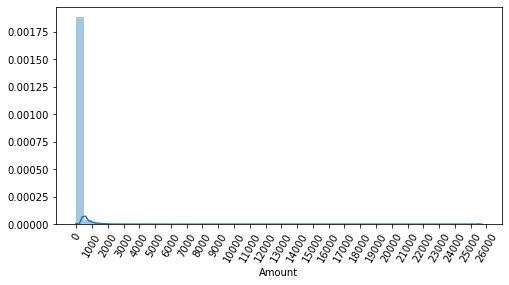

In [16]:
import seaborn as sns
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [17]:
# Amount를 표준 정규 분포 형태로 변환한 뒤 로지스틱 회귀 예측 성능 평가
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_scaled로 피처명 변경후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [18]:
# 함수 수정 후 get_train_test_dataset() 호출
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False) # boost_from_average 불균형한 데이터에 사용
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,     F1:0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,     F1:0.8409, AUC:0.9779


In [19]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [20]:
# Amount를 로그 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False) # boost_from_average 불균형한 데이터에 사용
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,     F1:0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,     F1:0.8496, AUC:0.9796


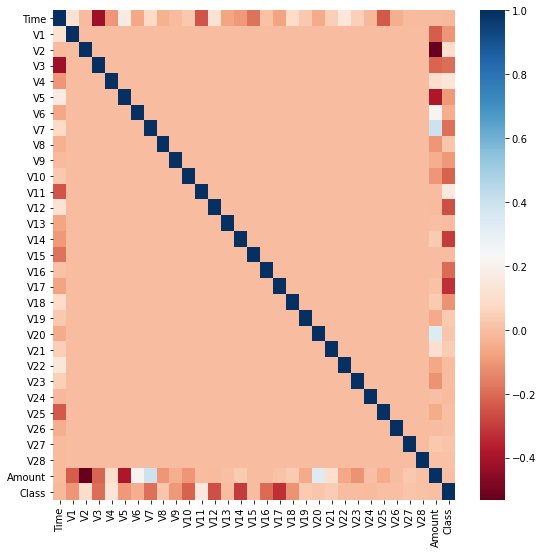

In [21]:
# 이상치 제거
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [22]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [23]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [24]:
# get_preprocessed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,     F1:0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,     F1:0.8897, AUC:0.9780


#### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [25]:
# SMOTE를 적용할 때는 반드시 학습 데이터 세트만 오버 샘플링을 해야함
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 1    199020
0    199020
Name: Class, dtype: int64


In [26]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,     F1:0.1023, AUC:0.9737


In [27]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 Scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

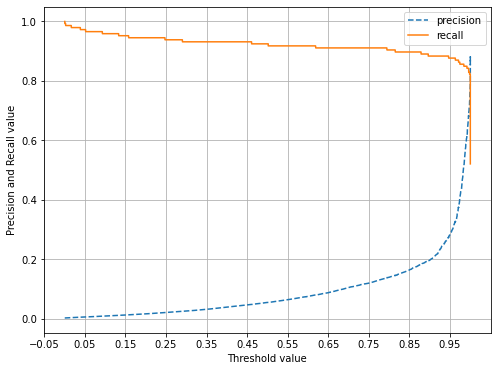

In [28]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [29]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,     F1:0.8794, AUC:0.9814


In [30]:
# SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적

### 스태킹 앙상블

In [32]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [34]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [36]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [37]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [38]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


In [41]:
# 과적합 개선을 위한 CV 세트 기반의 스태킹 모델
# 개별 모델들이 각각 교차 검증으로 메타 모델을 위한 학습용 스태킹 데이터 생성과 예측을 위한 테스트용 스태킹 데이터를 생성한 뒤 
# 이를 기반으로 메타 모델이 학습과 예측 수행
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds 값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트:', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터롱 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [42]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
RandomForestClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
AdaBoostClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작


In [44]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
     '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [45]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
